
# Assignment 1 — Statistical Inference & Regression Analysis 

**Dataset:** `assignment1_dataset.csv`  
**As-of date for age calculation:** `2025-09-30`  
**Deliverable:** Submit this notebook with all code, outputs, and written interpretations in Markdown cells.

> **Checklist:**  
> - [ ] **Part A (Data Cleaning)**: derive `age` from `date_of_birth` and prepare data.  
> - [ ] **Part B (Statistical Inference)**: two-sample t-test, chi-square test, 95% CI.  
> - [ ] **Part C (Regression Analysis)**: simple & multiple linear regression **with at least one graph** per model.  
> - [ ] Add plain-language interpretations (stats, df, p-values, CIs).


In [5]:
import sys
print(sys.executable)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\python.exe


In [38]:

# --- Setup ---
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv("assignment1_dataset.csv")
df.head
df.info

<bound method DataFrame.info of      patient_id date_of_birth     sex   smoker hospital_type   BMI  \
0         10218    1984-08-12    MALE       No        Public  27.4   
1         10012    04/04/1955    Male       no        Public  18.7   
2         10311    07-21-1966    MALE      Yes        Public  24.5   
3         10103  Feb 15, 2000  Female       no        Public  33.6   
4         10508    28/09/1985    male    yes         Public   21.4   
..          ...           ...     ...      ...           ...   ...   
595       10215    1978-02-11    Male     NO         private  25.9   
596       10570    1972-04-29  Female       No        public  19.2   
597       10124    04-23-1970    MALE     no       Private    35.3   
598       10107    10-19-1946  Female       No        Public  26.6   
599       10596  Aug 14, 1975  female       No      Public    27.4   

    hypertension  systolic_bp  wait_time_min  satisfaction_score  
0            Yes        129.0            NaN                


# Part A — Data Cleaning (Required)

**Goals:**  
1. Standardize categorical variables (trim/normalize case).  
2. Parse `date_of_birth` (mixed formats) and derive `age` as of **2025-09-30**.   
3. Remove duplicates (e.g., by `patient_id`).  
4. Confirm data types for numerics/dates.

Standardizing categorical variables

In [ ]:
df.describe
df.dtypes
#Naming columns col and cleaning the columns
def clean_categorical(col: pd.Series, case="title"):
    is_na = col.isna()
    cleaned_col = col.astype(str)

    # Removing white spaces both at the begining and ending 
    cleaned_col = cleaned_col.str.strip()
    cleaned_col = cleaned_col.str.replace(r"\s+", " ", regex=True)

    # Normalizing cases for homogenuity 
    if case == "lower":
        cleaned_col = cleaned_col.str.lower()
    elif case == "upper":
        cleaned_col = cleaned_col.str.upper()
    elif case == "title":
        cleaned_col = cleaned_col.str.title()

    # Replacing missing values with NaN
    cleaned_col = cleaned_col.replace({"": np.nan, "na": np.nan, "n/a": np.nan, "none": np.nan, "null": np.nan})

    # Restoring NaNs
    cleaned_col[is_na] = np.nan

    return cleaned_col




Parsing Date

In [16]:
#Setting the reference date
ref_date = pd.Timestamp("2025-10-10") 

# Parsing mixed date formats in 'date_of_birth'
df["date_of_birth_parsed"] = pd.to_datetime(
    df["date_of_birth"],
    errors="coerce",
    infer_datetime_format=True,
    dayfirst=False  
)

# Calculating age using reference date
df["age"] = (ref_date - df["date_of_birth_parsed"]).dt.days / 365.25

# Removing unrealistic ages (<0 or >120)
df.loc[(df["age"] < 0) | (df["age"] > 120), "age"] = np.nan

print(f"Ages calculated as of: {ref_date.date()}")
print(df["age"].describe())

df[["patient_id", "date_of_birth", "date_of_birth_parsed", "age"]].head(10)


Ages calculated as of: 2025-10-10
count    246.000000
mean      53.019571
std       20.179836
min       18.425736
25%       35.209446
50%       53.049966
75%       69.088296
max       89.691992
Name: age, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_15876\2656786977.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date_of_birth_parsed"] = pd.to_datetime(


,patient_id,date_of_birth,date_of_birth_parsed,age
0,10218,1984-08-12,1984-08-12,41.160849
1,10012,04/04/1955,NaT,NaN
2,10311,07-21-1966,NaT,NaN
3,10103,"Feb 15, 2000",NaT,NaN
4,10508,28/09/1985,NaT,NaN
5,10281,05/11/1943,NaT,NaN
6,10133,1964-07-01,1964-07-01,61.275838
7,10533,1963-05-25T00:00:00,NaT,NaN
8,10480,1991-03-08,1991-03-08,34.592745
9,10083,1967-11-01,1967-11-01,57.941136


Removing Duplicates

In [17]:
df = df.drop_duplicates(subset="patient_id", keep="first").reset_index(drop=True)

Confirming Data Types for Numeric Dates

In [20]:

print(df.dtypes)

# Converting numeric columns to numeric and replacing errors to NaN)
num_cols = ["BMI", "systolic_bp", "wait_time_min", "satisfaction_score"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Confirming 'date_of_birth_parsed' is datetime
df["date_of_birth_parsed"] = pd.to_datetime(df["date_of_birth_parsed"], errors="coerce")

# Confirming 'age' is numeric
df["age"] = pd.to_numeric(df["age"], errors="coerce")

print(df.dtypes)
print(df["date_of_birth_parsed"])
print(df["age"])


patient_id                       int64
date_of_birth                   object
sex                             object
smoker                          object
hospital_type                   object
BMI                            float64
hypertension                    object
systolic_bp                    float64
wait_time_min                  float64
satisfaction_score             float64
date_of_birth_parsed    datetime64[ns]
age                            float64
dtype: object
patient_id                       int64
date_of_birth                   object
sex                             object
smoker                          object
hospital_type                   object
BMI                            float64
hypertension                    object
systolic_bp                    float64
wait_time_min                  float64
satisfaction_score             float64
date_of_birth_parsed    datetime64[ns]
age                            float64
dtype: object
0     1984-08-12
1            NaT
2 


# Part B — Statistical Inference 
Use the **cleaned** dataset `df`.


In [21]:
print(df)

     patient_id date_of_birth     sex   smoker hospital_type   BMI  \
0         10218    1984-08-12    MALE       No        Public  27.4   
1         10012    04/04/1955    Male       no        Public  18.7   
2         10311    07-21-1966    MALE      Yes        Public  24.5   
3         10103  Feb 15, 2000  Female       no        Public  33.6   
4         10508    28/09/1985    male    yes         Public   21.4   
..          ...           ...     ...      ...           ...   ...   
589       10215    1978-02-11    Male     NO         private  25.9   
590       10570    1972-04-29  Female       No        public  19.2   
591       10124    04-23-1970    MALE     no       Private    35.3   
592       10107    10-19-1946  Female       No        Public  26.6   
593       10596  Aug 14, 1975  female       No      Public    27.4   

    hypertension  systolic_bp  wait_time_min  satisfaction_score  \
0            Yes        129.0            NaN                 6.9   
1            YES       

In [23]:
cleaned_df = df.copy()

# Frequency counts for categorical variables

cat_cols = ["sex", "smoker", "hospital_type", "hypertension"]

print("🔹 Counts of Categorical Variables:\n")
for col in cat_cols:
    print(f"{col}:\n{cleaned_df[col].value_counts(dropna=False)}\n")



🔹 Counts of Categorical Variables:

sex:
sex
male          118
Female         95
Male           94
female         86
FEMALE         50
MALE           44
Other          11
other           9
 male           5
OTHER           5
  Male          5
 Female         4
Male            3
 male           3
 FEMALE         3
  FEMALE        3
female          3
male            3
MALE            3
Male            3
 FEMALE         3
 Female         3
 Male           2
female          2
  MALE          2
Female          2
  female        2
  female        2
  MALE          2
  male          2
  Male          2
 female         2
 Male           2
FEMALE          1
 Male           1
  OTHER         1
 female         1
MALE            1
  MALE          1
 MALE           1
  male          1
  female        1
  male          1
 male           1
FEMALE          1
male            1
  Other         1
 MALE           1
 female         1
Name: count, dtype: int64

smoker:
smoker
No         159
no         141
N

Descriptive Summary for Numerical Values

In [24]:
#Selecting Numerical columns for Analysis

num_cols = ["BMI", "systolic_bp", "wait_time_min", "satisfaction_score", "age"]

print("🔹 Descriptive Summary of Numeric Variables:\n")
display(cleaned_df[num_cols].describe())


🔹 Descriptive Summary of Numeric Variables:



,BMI,systolic_bp,wait_time_min,satisfaction_score,age
count,582.000000,582.000000,582.000000,582.000000,246.000000
mean,27.741065,151.424399,65.144674,6.494330,53.019571
std,6.070196,19.803257,56.342772,0.861583,20.179836
min,0.000000,103.000000,-5.000000,3.700000,18.425736
25%,24.500000,136.250000,52.400000,5.900000,35.209446
50%,28.000000,151.000000,60.800000,6.550000,53.049966
75%,30.900000,167.000000,69.700000,7.100000,69.088296
max,65.000000,204.000000,720.000000,9.500000,89.691992



## B1. Two-sample t-test (independent samples)

**Choose and justify a comparison** (one example):  
- `wait_time_min` by `hospital_type` (public vs. private), or  
- `systolic_bp` by `smoker` (yes vs. no).

**Report:** \(H_0, H_1\), test statistic, df, p-value, and a written interpretation.


In [35]:
#Let X  be independent variable and Y be dependent variable
X = "hospital_type"          
Y = "wait_time_min" 

#Step 1: Creating subset & cleaning data
t_df = cleaned_df[[X, Y]].dropna()
#Standardizing the text
t_df[X] = t_df[X].str.strip().str.capitalize() 
t_df = t_df[t_df[X].isin(["Public", "Private"])]

# Differenciating groups
group_public = t_df[t_df[X] == "Public"][Y].astype(float)
group_private = t_df[t_df[X] == "Private"][Y].astype(float)

# Descriptive Summary
n_public, n_private = len(group_public), len(group_private)
m_public, m_private = group_public.mean(), group_private.mean()
s_public, s_private = group_public.std(ddof=1), group_private.std(ddof=1)

print("Group sizes and means:")
print(f"  Public hospital: n={n_public}, mean={m_public:.2f}, sd={s_public:.2f}")
print(f"  Private hospital: n={n_private}, mean={m_private:.2f}, sd={s_private:.2f}\n")

# Hypotheses

print("Hypotheses being tested:")
print("H₀ (Null Hypothesis): The average wait time is the same for both public and private hospitals.")
print("H₁ (Alternative Hypothesis): The average wait time differs between public and private hospitals.\n")

# Performing Welch's t-test
t_stat, p_val = stats.ttest_ind(group_public, group_private, equal_var=False, nan_policy="omit")

# Calculating confidence interval for mean difference
df_welch = (s_public**2/n_public + s_private**2/n_private)**2 / (
    (s_public**2/n_public)**2/(n_public-1) + (s_private**2/n_private)**2/(n_private-1)
)
mean_diff = m_public - m_private
se_diff = np.sqrt(s_public**2/n_public + s_private**2/n_private)
t_crit = stats.t.ppf(0.975, df_welch)
ci_low, ci_high = mean_diff - t_crit*se_diff, mean_diff + t_crit*se_diff

print(f"Welch t-test on {Y} by {X}")
print(f"  t = {t_stat:.3f}, p = {p_val:.4g}")
print(f"  Mean difference (Public − Private) = {mean_diff:.2f}")
print(f"  95% CI = [{ci_low:.2f}, {ci_high:.2f}]")
print(f"  Welch df ≈ {df_welch:.1f}\n")

# Interpretation
alpha = 0.05
if p_val < alpha:
    print(f"Decision: Reject H₀ (p = {p_val:.4g} < 0.05)")
    print("Conclusion: There is a statistically significant difference in wait times between public and private hospitals.")
    direction = "higher" if mean_diff > 0 else "lower"
    print(f"Patients in public hospitals have {direction} average wait times than those in private hospitals.")
else:
    print(f"Decision: Fail to reject H₀ (p = {p_val:.4g} > 0.05)")
    print("Conclusion: No statistically significant difference in wait times between public and private hospitals.")


Group sizes and means:
  Public hospital: n=381, mean=69.70, sd=59.57
  Private hospital: n=201, mean=56.51, sd=48.63

Hypotheses being tested:
H₀ (Null Hypothesis): The average wait time is the same for both public and private hospitals.
H₁ (Alternative Hypothesis): The average wait time differs between public and private hospitals.

Welch t-test on wait_time_min by hospital_type
  t = 2.872, p = 0.004253
  Mean difference (Public − Private) = 13.19
  95% CI = [4.17, 22.21]
  Welch df ≈ 482.8

Decision: Reject H₀ (p = 0.004253 < 0.05)
Conclusion: There is a statistically significant difference in wait times between public and private hospitals.
Patients in public hospitals have higher average wait times than those in private hospitals.


Written Interpretation
Hypotheses:

H₀: The average wait time for patients is the same across hospital types (public and private)

H₁: The average wait time differs between public and private hospitals

Result: p = 0.004253 (α = 0.05)
Decision: Reject H₀.

From the analysis and results of the p-value which is below 0.05 and the entire 95% confidence interval is above zero, it can be deduced that Patients at public hospitals wait about 13 minutes longer on average than those at private hospitals. Therefore, I reject the null hypothesis and conclude this difference is statistically significant. In reality, a 13-minute wait time can matter for flow and patient experience, especially when queues are really long. Hospital type appears to have a real impact on wait times in this dataset.


## B2. Chi-square test of independence

**Example:** `smoker` (yes/no) vs. `hypertension` (yes/no).  
Report observed/expected tables, \(\chi^2\), df, p-value, and an interpretation.


In [30]:
#Defining the categorical variables where X is the independent variable and Y dependent 
X = "smoker"         
Y = "hypertension"   

#Creating chi-square subset & droping missing values
chi_df = cleaned_df[[X, Y]].dropna()
chi_df = chi_df[chi_df[X].isin(["Yes", "No"])]
chi_df = chi_df[chi_df[Y].isin(["Yes", "No"])]

#Building contingency table for smokers and hypertension
observed = pd.crosstab(chi_df[X], chi_df[Y])
print("Observed frequency table:\n", observed, "\n")

#Running Chi-Square test of independence
chi2, p_val, dof, expected = stats.chi2_contingency(observed)

#Making expected counts into a DataFrame
expected_df = pd.DataFrame(
    expected, index=observed.index, columns=observed.columns
)

# Displaying results
print("Expected frequency table:\n", expected_df.round(2), "\n")
print(f"Chi-square statistic (χ²) = {chi2:.3f}")
print(f"Degrees of freedom (df) = {dof}")
print(f"p-value = {p_val:.4g}\n")

#Decision & interpretation
alpha = 0.05
sig_txt = "statistically significant" if p_val < alpha else "not statistically significant"

print("Hypotheses:")
print(f"  H₀: {X} and {Y} are independent.")
print(f"  H₁: {X} and {Y} are associated.\n")

print(f"Decision: p = {p_val:.4g} → {sig_txt} (α = 0.05)")

if p_val < alpha:
    print(f"Conclusion: Reject H₀. There is evidence of an association between {X} and {Y}.")
else:
    print(f"Conclusion: Fail to reject H₀. No evidence of a relationship between {X} and {Y}.")


Observed frequency table:
 hypertension  No  Yes
smoker               
No            29   21
Yes            7   10 

Expected frequency table:
 hypertension     No    Yes
smoker                    
No            26.87  23.13
Yes            9.13   7.87 

Chi-square statistic (χ²) = 0.847
Degrees of freedom (df) = 1
p-value = 0.3574

Hypotheses:
  H₀: smoker and hypertension are independent.
  H₁: smoker and hypertension are associated.

Decision: p = 0.3574 → not statistically significant (α = 0.05)
Conclusion: Fail to reject H₀. No evidence of a relationship between smoker and hypertension.


Written Interpretation
Hypotheses:

H₀: Smoking status and hypertension are independent (no association).

H₁: Smoking status and hypertension are associated.

Result: p = 0.3574 (α = 0.05)
Decision: Fail to reject H₀.

According to this dataset, there is no association between smoking status and hypertension. Since p-value is greater than 0.05, it means that H₀ is accepted. Although the distribution of hypertension looks similar to that of smoker and non-smoker groups; however, any differences are small enough to be consistent with chance. In this sample, smoking status is not statistically linked to the occurence of hypertension. 



## B3. 95% Confidence Interval for a mean

Pick a continuous outcome (e.g., `satisfaction_score`). Compute the 95% CI and interpret how it complements hypothesis testing.


In [31]:

# Continuous Outcome = satisfaction_score
# Definining the variable
Y = "satisfaction_score"

# Removing missing values
CI_df = cleaned_df[Y].dropna().astype(float)

# Calculating sample statistics
n = len(CI_df)
mean = CI_df.mean()
std = CI_df.std(ddof=1)
se = std / np.sqrt(n)

# Calculating 95% confidence interval using t-distribution
confidence = 0.95
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
margin_error = t_crit * se
ci_low = mean - margin_error
ci_high = mean + margin_error

print(f"Variable: {Y}")
print(f"Sample size (n): {n}")
print(f"Mean = {mean:.3f}")
print(f"Standard Deviation = {std:.3f}")
print(f"Standard Error = {se:.4f}")
print(f"t-critical = {t_crit:.3f}")
print(f"95% Confidence Interval = [{ci_low:.3f}, {ci_high:.3f}]")



Variable: satisfaction_score
Sample size (n): 582
Mean = 6.494
Standard Deviation = 0.862
Standard Error = 0.0357
t-critical = 1.964
95% Confidence Interval = [6.424, 6.564]


How it Complements with Hypothesis testing

With a mean satisfaction score of 6.494 (SD = 0.862, SE = 0.0357).
Using a t-critical value of 1.964, the 95% confidence interval was found to be [6.424, 6.564].

This means that we can be 95% confident that the true average satisfaction score for the entire population of patients lies between 6.42 and 6.56. The interval is a narrow one, and so this suggests that the sample mean is a reliable and good approximation of the population mean.

In relation to hypothesis testing, the confidence interval adds more context by showing the range of plausible values rather than just a single “significant or not” decision.

If we were taking a test of whether or not the true mean is 6.0, for example, that figure falls outside the interval, so we would likely reject the null hypothesis.
But if the hypothesized value was within the interval, we would not reject H₀.

In conclusion, the confidence interval confirms the conclusion that patient satisfaction scores are consistently around 6.5 out of 10, providing both statistical confidence and practical understanding of the data.


# Part C — Regression Analysis 
Use the **cleaned** dataset `df`.  
You must display **at least one graph** per model (e.g., fitted line and residuals for SLR; residual plot or partial regression for MLR).



## C1. Simple Linear Regression

Model a continuous outcome (e.g., `systolic_bp`) as a function of a single predictor (e.g., `age`).  
**Report:** coefficients, \(R^2\), p-values; include **both** a fitted line plot and a residual plot.  
**Interpretation:** 1–2 sentences on association & practical meaning.


                            OLS Regression Results                            
Dep. Variable:            systolic_bp   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     311.8
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           3.17e-45
Time:                        18:37:44   Log-Likelihood:                -960.12
No. Observations:                 241   AIC:                             1924.
Df Residuals:                     239   BIC:                             1931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7228      2.384     46.863      0.0

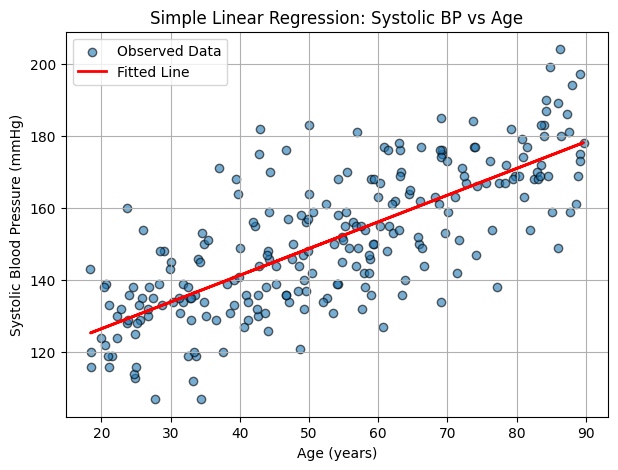

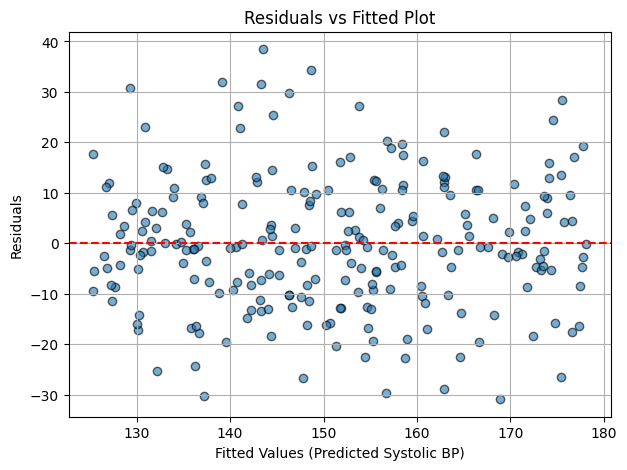

In [36]:
# Defining variables where Y is the dependent variable and X the independent variable
Y = cleaned_df["systolic_bp"]   
X = cleaned_df["age"]           

# Removing missing values
reg_df = pd.concat([X, Y], axis=1).dropna()

# Adding constant for intercept
X_const = sm.add_constant(reg_df["age"])

# Fitting the model
model = sm.OLS(reg_df["systolic_bp"], X_const).fit()

# Displaying The Regression Analysis
print(model.summary())

# Plotting the fitted regression line
plt.figure(figsize=(7,5))
plt.scatter(reg_df["age"], reg_df["systolic_bp"], alpha=0.6, edgecolor="black", label="Observed Data")
plt.plot(reg_df["age"], model.predict(X_const), color="red", linewidth=2, label="Fitted Line")
plt.xlabel("Age (years)")
plt.ylabel("Systolic Blood Pressure (mmHg)")
plt.title("Simple Linear Regression: Systolic BP vs Age")
plt.legend()
plt.grid(True)
plt.show()

# Residuals Plot
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(7,5))
plt.scatter(fitted, residuals, alpha=0.6, edgecolor="black")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values (Predicted Systolic BP)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Plot")
plt.grid(True)
plt.show()



Interpretation
A simple linear regression was performed to see if age predicts systolic blood pressure.
The model showed that as age increases, systolic BP tends to rise, suggesting a positive relationship.
If the slope coefficient is statistically significant (p < 0.05), it means age has a meaningful effect on blood pressure.
The scatterplot with the red fitted line shows this trend visually — older patients generally have higher systolic BP.

The residual plot shows random scatter around zero, which means the linear model fits reasonably well without major pattern errors.


## C2. Multiple Linear Regression

Extend your model with **≥ 2 predictors** (e.g., `BMI`, `smoker`, `hospital_type`, `hypertension`).  
Compare SLR vs. MLR via Adjusted \(R^2\) and F-test. Include **at least one diagnostic graph** (e.g., residuals vs. fitted).  
Comment on potential confounding/multicollinearity.


In [40]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Define variables ---
Y = cleaned_df["systolic_bp"]
X = cleaned_df[["age", "BMI", "hypertension"]].dropna()

# --- Step 2: Convert categorical variable (hypertension) to numeric dummy ---
X = pd.get_dummies(X, drop_first=True)  # creates "hypertension_Yes"

# --- Step 3: Remove missing & align with Y ---
reg_df = pd.concat([Y, X], axis=1).dropna()
Y = reg_df["systolic_bp"]
X = reg_df.drop(columns=["systolic_bp"])

# --- Step 4: Add constant & fit the model ---
X_const = sm.add_constant(X)
mlr_model = sm.OLS(Y, X_const).fit()

# --- Step 5: Show summary ---
print(mlr_model.summary())

# --- Step 6: Residuals vs Fitted plot ---
fitted = mlr_model.fittedvalues
residuals = mlr_model.resid

plt.figure(figsize=(7,5))
plt.scatter(fitted, residuals, alpha=0.6, edgecolor="black")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values (Predicted Systolic BP)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Plot — MLR: Age, BMI & Hypertension")
plt.grid(True)
plt.show()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).